In [172]:


import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt

import volpy_func_lib as vp
import load_clean_lib
import table_lib
import Robustness_Analysis
from mads_testing_stuff import RA_test_env

from IPython.display import display


In [173]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(RA_test_env)

<module 'RA_test_env' from 'D:\\Professionelt\\Code\\volpy\\RA_test_env.py'>

In [174]:
# importlib.reload(vp)
# importlib.reload(load_clean_lib)
# importlib.reload(table_lib)
# 
# 
# IV_type = "om" # om = OptionMetrics IV, "bid"/"ask"/"mid" price
# om_folder = "SPX_short" #i4s4_CW, SPX_short, SPX_full, i2s1_full_v2
# ticker_list = None #["SPX", "OEX"]
# 
# # Load data and clean
# od, returns_and_prices, od_raw = load_clean_lib.load_clean_and_prepare_od(om_folder = om_folder, tickers = ticker_list, first_day = None, last_day = None, IV_type = IV_type)
# print("Data loaded")
# 
# # Calculate results such as SW, RV ect.
# first_day=None
# last_day=None
# n_grid=200
# 
# if first_day is None:   first_day = od["date"].min()
# if last_day is None:    last_day = od["date"].max()
# 
# # Add low/high and create summary (Filters dataset for criteria such as min 3 strikes ... min 8 days...)
# od, summary_dly_df = vp.od_filter_and_summary_creater(od)
# summary_dly_df.reset_index(inplace=True)
# 
# # Add risk-free rate of the given date
# RF = load_clean_lib.download_factor_df(Factor_list=["FF5"])[['date', 'RF']]
# summary_dly_df = summary_dly_df.merge(RF[['date', 'RF']], on='date', how='left')
# 
# # Realized vol calculation
# real_vol = vp.calc_realized_var(returns_and_prices, first_day, last_day)
# 
# # Merge realized vol with summary_dly_df
# summary_dly_df = vp.add_realized_vol_to_summary(summary_dly_df, real_vol)
# 
# # only keep the lowest ("low") and the second lowest ("high") TTMs
# od_rdy = od[(od["low"] == True) | (od["high"] == True)]
# 
# # # Calculate high/low Swap Rates
# # summary_dly_df = vp.high_low_swap_rates(summary_dly_df, od_rdy, n_points=n_grid)

In [175]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(RA_test_env)


od_RA = Robustness_Analysis.create_fake_option_df(30/365.)

# parameter dicts you already have:
bs_params =    {'sigma':0.37, 'r':0.056}
mjd_params =   {'sigma':0.35, 'lam':0.4, 'mu_J':-0.09, 'sigma_J':0.18, 'r':0.056}
heston_params = {'kappa': 1.04, 'theta': 0.37**2, 'xi': 0.9, 'rho': -0.7}
svmjd_params = {**mjd_params, **heston_params}
svmjd_params['theta'] = 0.35**2

# 1) build your list‐of‐values column…
ln_vt_theta_vals = np.linspace(-3, 3, 13)
od_RA['ln vt/theta'] = od_RA['ticker'].apply(lambda t: [0] if t in ['BS','MJD'] else ln_vt_theta_vals)

# 2) explode it into real rows
od_RA = od_RA.explode('ln vt/theta').reset_index(drop=True)

# 3) coerce to float64
od_RA['ln vt/theta'] = od_RA['ln vt/theta'].astype(float)

# 4) now your v0 vectorized will work
def compute_v0(row):
    if row['ticker'] == 'BS':
        return bs_params['sigma']**2
    elif row['ticker'] == 'MJD':
        return mjd_params['sigma']**2
    elif row['ticker'] == 'Heston':
        return (np.exp(row['ln vt/theta']) * heston_params['theta'])
    elif row['ticker'] == 'SVMJD':
        return (np.exp(row['ln vt/theta']) * svmjd_params['theta'])
    else:
        return np.nan

od_RA['v0'] = od_RA.apply(compute_v0, axis=1)

# fill your DataFrame’s IV column:
od_RA['Price'] = Robustness_Analysis.price_model(
    od_RA['F'].values,
    od_RA['K'].values,
    od_RA['t_TTM'].values,
    od_RA['cp_flag'].values,
    od_RA['ticker'].values,
    od_RA['v0'].values,
    bs_params,
    mjd_params,
    heston_params,
    svmjd_params
)
od_RA['IV'] = vp.add_bid_mid_ask_IV(od_RA, "Price")

TypeError: create_fake_option_df() takes 0 positional arguments but 1 was given

In [169]:
od_RA["date"] = od_RA["v0"]
df_swaps_low = vp.process_od_rdy_parallel(od_RA[od_RA["low"]], vp.replicate_SW, n_points=2000)
df_swaps_high = vp.process_od_rdy_parallel(od_RA[od_RA["high"]], vp.replicate_SW, n_points=2000)
od_RA.rename(columns={"ticker": "model"}, inplace=True)

# 2) Extract low/high rows and merge
df_low = (
    df_swaps_low
    .drop_duplicates(["ticker", "v0"])
    .loc[:, ["ticker", "v0", "var_swap_rate", "ln vt/theta"]]
    .rename(columns={"var_swap_rate": "low SW"})
)

df_high = (
    df_swaps_high
    .drop_duplicates(["ticker", "v0"])
    .loc[:, ["ticker", "v0", "var_swap_rate"]]
    .rename(columns={"var_swap_rate": "high SW"})
)

df_merged = pd.merge(df_low, df_high, on=["ticker", "v0"], how="outer")
df_merged.set_index(["ticker", "ln vt/theta"], inplace=True)

Processing Groups: 100%|██████████| 28/28 [00:02<00:00, 11.75it/s]


In [170]:
dt = 1/12
A = (1 - np.exp(-svmjd_params['kappa']*dt)) / (svmjd_params['kappa']*dt)

# Compute analytic value per row
def analytic_value(row):
    model = row["model"]  # ticker is the index
    v0 = row['v0']
    if model == 'BS':
        return bs_params['sigma']**2
    elif model == 'MJD':
        return mjd_params['sigma']**2 + mjd_params['lam'] * (mjd_params['mu_J']**2 + mjd_params['sigma_J']**2)
    elif model == 'Heston':
        return heston_params['theta'] + A * (v0 - heston_params['theta'])
    elif model == 'SVMJD':
        return (svmjd_params['theta'] + A * (v0 - svmjd_params['theta']) + svmjd_params['lam'] * (svmjd_params['mu_J']**2 + svmjd_params['sigma_J']**2))
    else:
        return np.nan

df_merged.reset_index(inplace=True)
df_merged.rename(columns={"ticker": "model"}, inplace=True)
df_merged.rename(columns={"low SW": "SW"}, inplace=True)
df_merged['analytic'] = df_merged.apply(analytic_value, axis=1)
df_merged['error'] = df_merged['analytic'] - df_merged['SW']
df_merged['error pct'] = df_merged['error'] / df_merged['analytic'] * 100
df_merged['error jmp'] = -2 * mjd_params['lam'] * (np.exp(mjd_params['mu_J'] + 0.5*mjd_params['sigma_J']**2) - 1 - mjd_params['mu_J'] - 0.5*(mjd_params['mu_J']**2 + mjd_params['sigma_J']**2))

cols_to_front = ["ln vt/theta", "model", "analytic", "SW", "error", "error pct", "error jmp"]
remaining_cols = [col for col in df_merged.columns if col not in cols_to_front]
df_merged = df_merged[cols_to_front + remaining_cols]

In [171]:
with pd.option_context('display.max_rows', None):
    display(df_merged)

,ln vt/theta,model,analytic,SW,error,error pct,error jmp,v0,high SW
0,0.0,BS,0.136900,0.136899,7.141882e-07,0.000522,0.001114,0.136900,0.136899
1,-3.0,Heston,0.012293,0.018465,-6.171480e-03,-50.201359,0.001114,0.006816,0.020055
2,-2.5,Heston,0.016529,0.022641,-6.111795e-03,-36.976522,0.001114,0.011237,0.021272
3,-2.0,Heston,0.023512,0.027469,-3.957274e-03,-16.830975,0.001114,0.018527,0.026436
4,-1.5,Heston,0.035025,0.035781,-7.565537e-04,-2.160047,0.001114,0.030547,0.036197
5,-1.0,Heston,0.054007,0.054413,-4.064568e-04,-0.752606,0.001114,0.050363,0.054231
6,-0.5,Heston,0.085302,0.085213,8.901931e-05,0.104358,0.001114,0.083034,0.085365
7,0.0,Heston,0.136900,0.136153,7.472541e-04,0.545839,0.001114,0.136900,0.136892
8,0.5,Heston,0.221970,0.220359,1.611514e-03,0.726004,0.001114,0.225710,0.221924
9,1.0,Heston,0.362228,0.359629,2.598881e-03,0.717472,0.001114,0.372133,0.362016


C:\Users\User\AppData\Local\Temp\ipykernel_16544\2797404264.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_16544\2797404264.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_16544\2797404264.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_16544\2797404264.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()


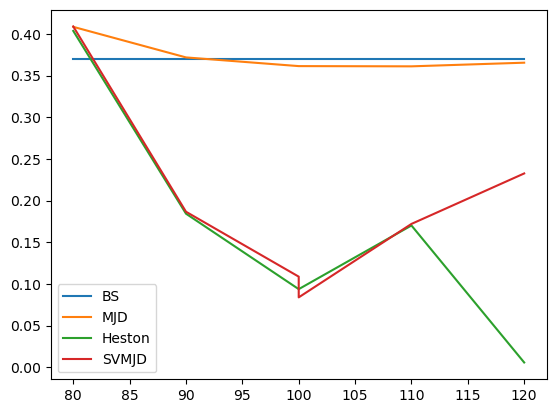

In [165]:
# df_BS = od_RA[(od_RA["ticker"] == "BS") & (od_RA["high"] == True)].reset_index()
# df_MJD = od_RA[(od_RA["ticker"] == "MJD") & (od_RA["low"] == True)].reset_index()
# df_Heston = od_RA[(od_RA["ticker"] == "Heston") & (od_RA["high"] == True)].reset_index()

od_RA_ = od_RA[(od_RA["ln vt/theta"] == -3) | (od_RA["model"].isin(["BS", "MJD"]))]
for model in ["BS", "MJD", "Heston", "SVMJD"]:
    df = od_RA_[(od_RA["model"] == model) & (od_RA_["low"] == True)].reset_index()
    plt.plot(df["K"], df["IV"], label = f"{model}")
plt.legend()
plt.show()